In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base=automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
latest_date = (session.query(Measurement.date)
                .order_by(Measurement.date.desc())
                .first())
latest_date

('2017-08-23')

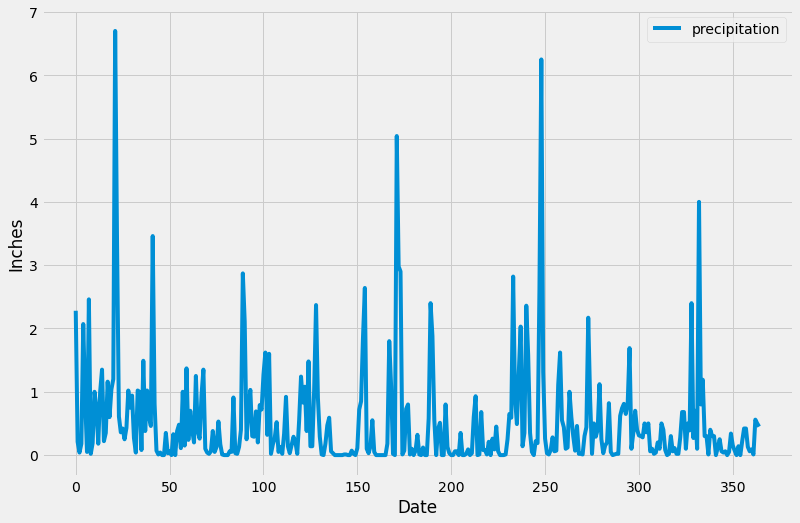

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_year_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
year_precipitation = (session.query(Measurement.date,func.max(Measurement.prcp))
                      .filter(func.strftime(Measurement.date) > last_year_date)
                      .group_by(Measurement.date)
                      .all())

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(year_precipitation, columns = ['date', 'precipitation'])

# Sort the dataframe by date
precipitation_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.rcParams['figure.figsize']=(12,8)
precipitation_df.plot(linewidth=4)

plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()




In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_precipitation_stats=(session.query(Measurement.date, Measurement.prcp)
                            .filter(Measurement.date > last_year_date)
                            .all())
year_precipitation_stats

precipitation_stats = pd.DataFrame(year_precipitation_stats, columns=['date', 'prcp'])
precipitation_stats.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
locations = session.query(Measurement).group_by(Measurement.station).count()
print(locations)

9


In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = (session.query(Measurement.station, func.count(locations))
                   .group_by(Measurement.station)
                   .order_by(func.count(locations).desc())
                   .all())
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
top_station = active_stations[0][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == top_station).all()

[(54.0, 71.66378066378067, 85.0)]

<function matplotlib.pyplot.show(*args, **kw)>

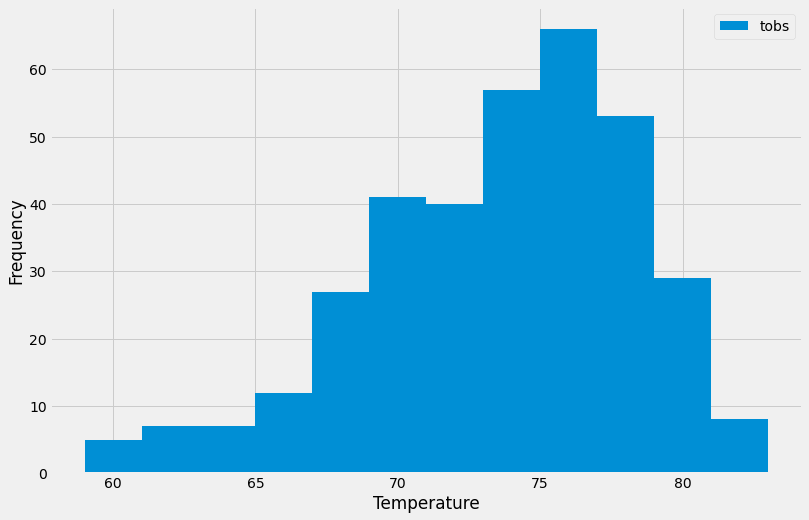

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = (session.query(Measurement.station, Measurement.tobs)
                .filter(Measurement.station == top_station)
                .filter(Measurement.date >= last_year_date)
                .order_by(Measurement.date.desc())
                .all())

temp_df = pd.DataFrame(temp_results)

temp_df.plot.hist(by = 'station', bins = 12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show

# Close session

In [16]:
# Close Session
session.close()